# Homeschooler shokunin challenge

Run all cells and check the **output according to problem spec**

# Tasks

Define tasks data and utility methods

In [1]:
tasks_2 = {'A': 5,
           'B': 1,
           'C': 4}

tasks_aye = {'A': 2,
             'B': 5,
             'C': 1,
             'D': 6,
             'E': 4,
             'F': 2,
             'G': 1,
             'H': 3,
             'I': 2,
             'J': 2}

tasks_yes = {'A': 5,
             'B': 4,
             'C': 1,
             'D': 2,
             'E': 7,
             'F': 8,
             'G': 3}

tasks_nup = {'A': 5,
             'B': 4,
             'C': 1,
             'D': 2,
             'E': 7,
             'F': 12,
             'G': 2}

In [2]:
def efforts(tasks):
  return [t[1] for t in tasks.items()]

def total_effort(tasks):
  return sum(efforts(tasks))

def can_sum_split(tasks, n):
  return total_effort(tasks) % n == 0

def child_target_load(tasks, n):
  return total_effort(tasks) // n

def oversize_tasks(tasks, n):
  return max(efforts(tasks)) > child_target_load(tasks, n)   

In [3]:
can_sum_split(tasks_nup, 3)

True

In [4]:
oversize_tasks(tasks_yes, 3)

False

# Solver

The assignment of tasks to children is a vector of length m (where m is the number of tasks). Each element of the vector is the index of the child to which that task is assigned (values 0...n-1)

These are ultility methods for the simulated annealing solver

In [5]:
import math
import numpy as np

# calculate the loads for each child (list length n)
def loads(tasks, n, assignment):
  loads = [0] * n
  tks = sorted(list(tasks.keys()))
  for i, c in enumerate(assignment):
    loads[c] = loads[c] + tasks[tks[i]]
  return loads

print(loads(tasks_2, 2, [0, 1, 1]))

# calculate energy functions for simulated annealing
def energy(tasks, n, assignment):
  targets = [child_target_load(tasks, n)] * n
  deltas = np.array(loads(tasks, n, assignment)) - np.array(targets)
  return sum(abs(deltas))

def energy_binary(tasks, n, assignment):
  return int(energy(tasks, n, assignment) > 0)

# define neighbors of a task assignment
# where exactly one task is assigned to another child
def neighbours(n, assignment):
  neighbours = []
  for i, _ in enumerate(assignment):
    for r in range(1, n):
      neighbour = assignment.copy()
      neighbour[i] = (neighbour[i] + r) % n
      neighbours.append(neighbour)
  return neighbours

print(neighbours(2, [0, 0, 1]))

# distance between two assignments
def distance(a0, a1):
  return sum([x1 != x0 for x0, x1 in zip(a0, a1)])

print([distance(n, [0, 0, 0]) for n in neighbours(2, [0, 0, 1])])

# playing around with symmetries
def classes(assignment):
  class_dict = {}
  class_list = []
  for t in assignment:
    if not t in class_dict:
      class_dict[t] = len(class_dict)
    class_list.append(class_dict[t])
  return class_list

def symmetrical(a0, a1):
  return tuple(classes(a0)) == tuple(classes(a1))

# simulated annealing P() function
def accept_prob(e0, e1, t):
  return 1 if e1 < e0 else math.exp(-(e1 - e0) / t)

[5, 5]
[[1, 0, 1], [0, 1, 1], [0, 0, 0]]
[2, 2, 0]


This is the simulated annealing solver itself

In [6]:
import random

# todo - avoid revisiting states
# todo - consider symmetry somehow - is it in the revisiting?

def solve(tasks, n, initial_assignment, steps, energy_fn):
  solved = False
  assignment = initial_assignment
  e0 = energy_fn(tasks, n, assignment)
  es = [e0]
  ss = [assignment]
  for k in range(steps):
    t = (k + 1) / steps
    if e0 == 0:
      solved = True
      break
    candidate = random.choice(neighbours(n, assignment))
    e1 = energy_fn(tasks, n, candidate)
    es.append(e1)
    ss.append(candidate)
    if accept_prob(e0, e1, t) >= random.random():
      assignment = candidate
      e0 = e1
  return solved, assignment, k, es, ss

# Initial assignment of tasks

Define where the solver starts

In [7]:
def assign_round_robin(tasks, n):
  tks = sorted(list(tasks.keys()))
  sorted_tasks = {k: v for k, v in reversed(sorted(tasks.items(), key=lambda x: x[1]))}
  assignment = [-1] * len(tks)
  i = 0
  di = 1
  for k in sorted_tasks:
    j = tks.index(k)
    assignment[j] = i
    i = i + di
    if i >= n:
      i = i - di
      di = -1
    if i <= 0:
      i = i - di
      di = 1
  return assignment

def assign_single(tasks, i):
  return [i] * len(tasks)

def count_all_assignments(tasks, n):
  return n ** len(tasks)

print(assign_round_robin(tasks_yes, 3))

[2, 2, 2, 1, 1, 0, 1]


# Run solver and display results

Basic solver run

Solver: (True, [2, 2, 2, 0, 1, 0, 1], 25)


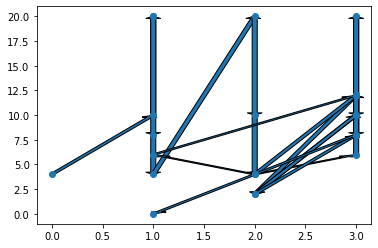

In [8]:
# run solver
out = solve(tasks_yes, 3, assign_round_robin(tasks_yes, 3), 2000, energy)
print('Solver: {}'.format(out[:3]))

# and for good measure plot energy
import matplotlib.pyplot as plt
plt.plot([distance(s, out[4][0]) for s in out[4]], out[3], "o")
for i in range(1, len(out[4])):
  ps = [(distance(x, out[4][0]), y) for x, y in zip(out[4], out[3])]
  plt.arrow(ps[i - 1][0], ps[i - 1][1], ps[i][0] - ps[i - 1][0], ps[i][1] - ps[i - 1][1], width=0.05, length_includes_head=True)
#plt.arrow(0,0, 1,1)
plt.show()

**Output according to problem spec**

In [9]:
def pretty_print(tasks, n, assignment):
  tks = sorted(list(tasks.keys()))
  ls = loads(tasks, n, assignment)
  for i in range(n):
    ca = [j for j, c in enumerate(assignment) if c == i]
    ca_strs = ['Task {} ({} points)'.format(tks[j], tasks[tks[j]]) for j in ca]
    ca_str = ' + '.join(ca_strs)
    print('Child {}: {} = {} points'.format(i + 1, ca_str, ls[i]))

def run(tasks, n):
  no_solution = not can_sum_split(tasks, n) or oversize_tasks(tasks, n)
  if not no_solution:
    output = solve(tasks, n, assign_round_robin(tasks, n), 2000, energy)
  
  if no_solution or not output[0]:
    print('No')
    return

  print('Yes')
  pretty_print(tasks, n, output[1])

run(tasks_yes, 3)

Yes
Child 1: Task D (2 points) + Task F (8 points) = 10 points
Child 2: Task E (7 points) + Task G (3 points) = 10 points
Child 3: Task A (5 points) + Task B (4 points) + Task C (1 points) = 10 points


# Compare effectiveness

Compare round robin assignment vs single child assignment as initial state and compare continuous energy function vs binary energy function.

In [10]:
out_rbn_cnt = []
out_sgl_cnt = []
out_rbn_bin = []
out_sgl_bin = []

for i in range(2000):
  out_rbn_cnt.append(solve(tasks_yes, 3, assign_round_robin(tasks_yes, 3), 2000, energy)[2])
  out_sgl_cnt.append(solve(tasks_yes, 3, assign_single(tasks_yes, 0), 2000, energy)[2])
  out_rbn_bin.append(solve(tasks_yes, 3, assign_round_robin(tasks_yes, 3), 2000, energy_binary)[2])
  out_sgl_bin.append(solve(tasks_yes, 3, assign_single(tasks_yes, 0), 2000, energy_binary)[2])

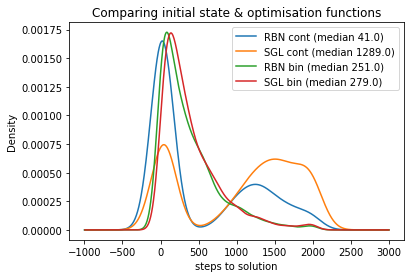

In [11]:
# visualise results
import pandas as pd
import statistics

df = pd.DataFrame(np.transpose(np.array([out_rbn_cnt, out_sgl_cnt, out_rbn_bin, out_sgl_bin])),
                  columns=['RBN cont (median {})'.format(statistics.median(out_rbn_cnt)),
                           'SGL cont (median {})'.format(statistics.median(out_sgl_cnt)),
                           'RBN bin (median {})'.format(statistics.median(out_rbn_bin)),
                           'SGL bin (median {})'.format(statistics.median(out_sgl_bin))])
df.plot.kde()
plt.title('Comparing initial state & optimisation functions')
plt.xlabel('steps to solution')
plt.show()

# Brute force solver

Just for kicks

In [12]:
def brute(tasks, n, steps):
  solved = False
  assignment = [0] * len(tasks)
  e0 = energy_binary(tasks, n, assignment)
  es = [e0]
  variant = sum([t * n ** (len(tasks) - i - 1) for i, t in enumerate(assignment)])
  for k in range(steps):
    if e0 == 0:
      solved = True
      break
    variant = (variant + 1) % n ** len(tasks)
    candidate = [variant % n ** i // n ** (i - 1) for i in range(len(tasks), 0, -1)]
    e1 = energy_binary(tasks, n, candidate)
    es.append(e1)
    assignment = candidate
    e0 = e1
  return solved, assignment, k, es

In [13]:
# run solver
out = brute(tasks_yes, 3, 2000)
print('Brute: {}'.format(out[:3]))

Brute: (True, [0, 0, 0, 1, 2, 1, 2], 50)
